# lg3 exog-only power demo

Predict `Power` using exogenous features only (holiday/week/day/fourier).

In [141]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# --- config ---
PROCESSED_ROOT = os.path.abspath(os.path.join('..', 'data', 'processed_sources'))
EXOG_ROOT = os.path.abspath(os.path.join('..', 'data', 'exog_sources'))
SOURCE = 'snu'  # elec1_f2 / ohsung_f2 / snu
SPLIT = 'train'  # train / val / test
TARGET_COL = 'Power'
TRAIN_RATIO = 0.8
EPOCHS = 100
LR = 1e-3


In [142]:
df_path = os.path.join(PROCESSED_ROOT, SOURCE, f'lg3_{SPLIT}.csv')
exog_path = os.path.join(EXOG_ROOT, SOURCE, f'lg3_{SPLIT}_exog.npy')

df = pd.read_csv(df_path, parse_dates=[0], index_col=0)
y = df[TARGET_COL].to_numpy(dtype=np.float32)
X = np.load(exog_path).astype(np.float32)

if len(X) != len(y):
    raise ValueError(f'Length mismatch: X={len(X)}, y={len(y)}')

X = np.nan_to_num(X, nan=0.0)

# train/test split by time
n = len(y)
split_idx = int(n * TRAIN_RATIO)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# normalize (fit on train only)
X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-6
X_train_n = (X_train - X_mean) / X_std
X_test_n = (X_test - X_mean) / X_std

y_mean = y_train.mean()
y_std = y_train.std() + 1e-6
y_train_n = (y_train - y_mean) / y_std
y_test_n = (y_test - y_mean) / y_std

print('X shape:', X.shape, 'y shape:', y.shape)
print('train size:', len(y_train), 'test size:', len(y_test))


X shape: (18337, 6) y shape: (18337,)
train size: 14669 test size: 3668


In [144]:
class ExogMLP(torch.nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(in_dim, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1),
        )

    def forward(self, x):
        return self.net(x)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = ExogMLP(X_train_n.shape[1]).to(device)
opt = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = torch.nn.MSELoss()

X_train_t = torch.from_numpy(X_train_n).to(device)
y_train_t = torch.from_numpy(y_train_n).to(device).view(-1, 1)

for epoch in range(EPOCHS):
    model.train()
    opt.zero_grad()
    pred = model(X_train_t)
    loss = loss_fn(pred, y_train_t)
    loss.backward()
    opt.step()
    if (epoch + 1) % 5 == 0:
        print(f'epoch {epoch+1} | train mse {loss.item():.6f}')


epoch 5 | train mse 1.008225
epoch 10 | train mse 0.954531
epoch 15 | train mse 0.909723
epoch 20 | train mse 0.872557
epoch 25 | train mse 0.841984
epoch 30 | train mse 0.817071
epoch 35 | train mse 0.797195
epoch 40 | train mse 0.781731
epoch 45 | train mse 0.770035
epoch 50 | train mse 0.761333
epoch 55 | train mse 0.754845
epoch 60 | train mse 0.749928
epoch 65 | train mse 0.746023
epoch 70 | train mse 0.742723
epoch 75 | train mse 0.739773
epoch 80 | train mse 0.737020
epoch 85 | train mse 0.734399
epoch 90 | train mse 0.731856
epoch 95 | train mse 0.729351
epoch 100 | train mse 0.726893


In [145]:
model.eval()
with torch.no_grad():
    X_test_t = torch.from_numpy(X_test_n).to(device)
    pred_test_n = model(X_test_t).cpu().numpy().reshape(-1)

pred_test = pred_test_n * y_std + y_mean
mse = np.mean((y_test - pred_test) ** 2)
mae = np.mean(np.abs(y_test - pred_test))
print(f'Test MSE: {mse:.6f} | MAE: {mae:.6f}')


Test MSE: 1.238184 | MAE: 0.800718


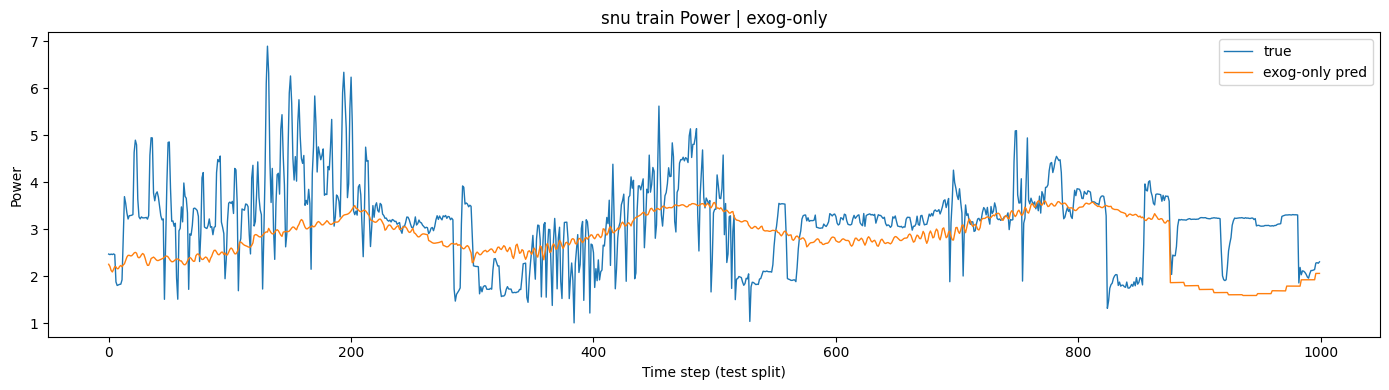

In [146]:
# plot a slice of test predictions
plot_len = min(1000, len(y_test))
plt.figure(figsize=(14, 4))
plt.plot(y_test[:plot_len], label='true', linewidth=1.0)
plt.plot(pred_test[:plot_len], label='exog-only pred', linewidth=1.0)
plt.title(f'{SOURCE} {SPLIT} {TARGET_COL} | exog-only')
plt.xlabel('Time step (test split)')
plt.ylabel(TARGET_COL)
plt.legend()
plt.tight_layout()
plt.show()
